## Intro

In this notebook we introduce some pipeline concepts.

We have to create 3 objects:
- One for RobustScaler transformation.
- Another to re-structure the data.
- And the third, to train the model (or predict)

## LIBRARIES

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae

import pipe_needs

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from datetime import datetime


2023-03-26 17:08:13.327920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 17:08:14.051935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/y41000/miniconda3/envs/tensorfl/lib/:/home/y41000/miniconda3/envs/tensorfl/lib/
2023-03-26 17:08:14.052054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/y41000/miniconda3/envs/tensorfl/lib/

In [2]:
ventana = 120 #10 días
n_features = 1
epochs = 100
corte_fecha = 201212
corte_train_test = 202208
INPUTPATH = '/home/y41000/repos/basic-sklearn-pipeline/'

## DATA GENERAL PRE-PROCESSING

In [3]:
# Read.
data1 = pd.read_csv(INPUTPATH+'data/EURUSD_Candlestick_1_h_ASK_31.12.2011-31.01.2023.csv', usecols = ['Gmt time','Close'])

# Basic transformations.
data1['fecha'] = pd.to_datetime(data1['Gmt time'],format='%d.%m.%Y %H:%M:%S.%f')
data1[f'precio_EURUSD'] = data1['Close']

# Select records from 2013 onwards.
data1 = data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)>corte_fecha]

# Temporal order.
data1.sort_values('fecha',inplace=True)

# NULOS
# For the null values we will take the preceed value.
data1['precio_EURUSD'] = data1['precio_EURUSD'].fillna(method='ffill')
# Except when we do not have a preceed value, then we will take the next value.
data1['precio_EURUSD'] = data1['precio_EURUSD'].fillna(method='bfill')

# Target and TRAIN/TEST.
X_train=data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)< corte_train_test][['fecha','precio_EURUSD']]
X_test =data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)>=corte_train_test][['fecha','precio_EURUSD']]
y_train=data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)< corte_train_test][['fecha','precio_EURUSD']].rename(columns={'precio_EURUSD':'target'})
y_train['target'] = y_train['target'].shift(-1).fillna(method='ffill')
y_test =data1[(data1['fecha'].dt.year*100+data1['fecha'].dt.month)>=corte_train_test][['fecha','precio_EURUSD']].rename(columns={'precio_EURUSD':'target'})
y_test['target'] = y_test['target'].shift(-1).fillna(method='ffill')

y_train = y_train['target'].values
y_test= y_test['target'].values

y_train = y_train[ventana-1:len(y_train) ]
y_test = y_test[ventana-1:len(y_test) ]

# NORMALIZE.
X_train.set_index('fecha',inplace=True)
X_test.set_index('fecha',inplace=True)



## PIPE-LINE



In [4]:
LSTM_pipe = Pipeline([
    # === SCALING ===
    ('Normalization the data with Robust Scaler', RobustScaler()),

    # === RE-STRUCTURE ===
    ('Fit the data to the LSTM input structure', pipe_needs.ReestructuraLSM(ventana)),

    # === MODEL ===
    ('LSTM Model', pipe_needs.ModeloLSM(ventana,n_features,epochs))
])



In [5]:
LSTM_pipe.fit(X_train,y_train)


2023-03-26 17:08:20.334062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 17:08:20.338782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 17:08:20.338983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 17:08:20.339514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/100


2023-03-26 17:08:22.691326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-26 17:08:22.964705: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6c7a0ded20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-26 17:08:22.964748: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-03-26 17:08:22.969007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-26 17:08:23.105064: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1862/1862 [==============================] - 12s 5ms/step - loss: 0.0109
Epoch 2/100
1862/1862 [==============================] - 10s 5ms/step - loss: 4.7591e-06
Epoch 3/100
1862/1862 [==============================] - 10s 5ms/step - loss: 8.4930e-06
Epoch 4/100
1862/1862 [==============================] - 10s 5ms/step - loss: 9.3833e-06
Epoch 5/100
1862/1862 [==============================] - 10s 5ms/step - loss: 8.4668e-06
Epoch 6/100
1862/1862 [==============================] - 10s 5ms/step - loss: 7.1496e-06
Epoch 7/100
1862/1862 [==============================] - 10s 5ms/step - loss: 5.3125e-06
Epoch 8/100
1862/1862 [==============================] - 10s 5ms/step - loss: 4.9943e-06
Epoch 9/100
1862/1862 [==============================] - 10s 5ms/step - loss: 4.3086e-06
Epoch 10/100
1862/1862 [==============================] - 10s 5ms/step - loss: 4.1108e-06
Epoch 11/100
1862/1862 [==============================] - 10s 5ms/step - loss: 3.8706e-06
Epoch 12/100
1862/1862 [===========

1862/1862 [==============================] - 10s 5ms/step - loss: 1.8135e-06
Epoch 93/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.9265e-06
Epoch 94/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.8810e-06
Epoch 95/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.8418e-06
Epoch 96/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.8645e-06
Epoch 97/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.8628e-06
Epoch 98/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.8838e-06
Epoch 99/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.8394e-06
Epoch 100/100
1862/1862 [==============================] - 10s 5ms/step - loss: 1.8604e-06


Pipeline(steps=[('Normalization the data with Robust Scaler', RobustScaler()),
                ('Fit the data to the LSTM input structure',
                 <pipe_needs.ReestructuraLSM object at 0x7f6e9f1f30d0>),
                ('LSTM Model',
                 <pipe_needs.ModeloLSM object at 0x7f6e9f1f32b0>)])

In [6]:

yhat_train = LSTM_pipe.transform(X_train)
yhat_test = LSTM_pipe.transform(X_test)

96/96 [==============================] - 0s 2ms/step


## TEST

**ERRORS**

In [7]:
rmse_test = rmse(y_test,yhat_test.flatten(), squared=False)
mae_test = mae(y_test,yhat_test.flatten())



In [8]:
print(f'RMSE: {rmse_test}\nRMSE/Promedio: {round(100*rmse_test/y_test.mean(),4)}%\n\nMAE: {mae_test}\nMAE/Promedio: {round(100*mae_test/y_test.mean(),4)}%')



RMSE: 0.0015603555904982647
RMSE/Promedio: 0.1523%

MAE: 0.001030043973885478
MAE/Promedio: 0.1005%


**SIGNS**

How many times the model hits when says that the price goes up or goes down?

In [9]:

signo = np.sign(y_test[1:]-y_test[:-1])
signohat = np.sign(yhat_test.flatten()[1:]-yhat_test.flatten()[:-1])
pd.crosstab(signo,signohat)

col_0,-1.0,1.0
row_0,,
-1.0,709,806
0.0,7,12
1.0,809,728


The same than before but demanding a minimun variation.

In [10]:

signo = np.where(np.abs(y_test[1:]-y_test[:-1])>0.00059,signo,0)
signohat = np.where(np.abs(yhat_test.flatten()[1:]-yhat_test.flatten()[:-1])>0.00099,signohat,0)
pd.crosstab(signo,signohat)

col_0,-1.0,0.0,1.0
row_0,,,
-1.0,154,484,187
0.0,200,1033,183
1.0,185,487,158


**CHART**

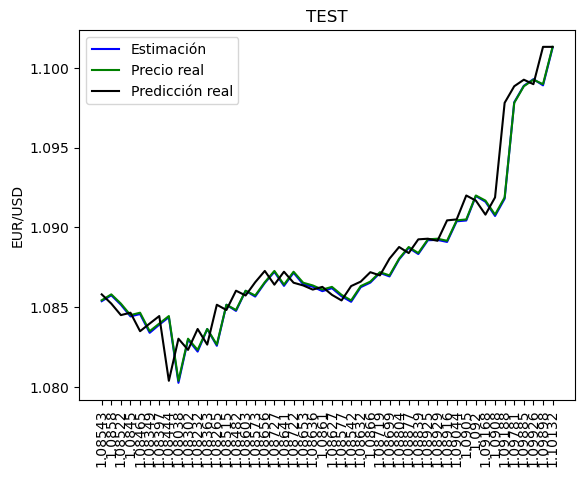

In [11]:
plt.plot(yhat_test.flatten()[-48:], color='blue', label='Estimación')
plt.plot(data1['precio_EURUSD'].values[-48:], color='green', label='Precio real')
plt.plot(y_test[-48:], color='black', label='Predicción real')
plt.legend()
plt.ylabel('EUR/USD')
plt.xticks(range(48),data1['precio_EURUSD'].astype(str).values[-48:],rotation=90)
#plt.xticks(range(48),[x[1] if x[0]%10==0 else '' for x in enumerate(Yte['fecha'].astype(str).values[-48:])],rotation=90)
plt.title('TEST')
plt.rc('figure', figsize=(30, 15))

plt.show()

## SAVE (notebook)



In [12]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

As we can see, the best solution found by the model is a almost identical serie as original.